In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import fsolve
from scipy.spatial.distance import cdist

Physical constants:

In [2]:
# copied from constants-units

EAU = 27.2114
IAU = 3.5e16
LAU = 0.052918
TAU = 2.419e-17
alpha = 1. /137
c = 1/alpha


In [3]:
# #EAU = 27.2114
# IAU = 3.5e16
# #LAU = 0.052918
# TAU = 2.419e-17
# #alpha = 1. /137
# c = 2.998e8  # Speed of light in m/s
# LAU = 5.29177e-11  # Bohr radius in meters
# #c = 1/alpha


Field configurations:

In [4]:
### in SI units
wavelength = 800 #e-9 #Wavelength in nm
Int_0 = 4e14 #Intensity in W/cm2
Ip = 0.5 * 13.5984 # Hydrogen gas target ionization potential in eV

#### conversion to atomic units
omega = 2 * np.pi * LAU * c / wavelength  # Angular frequency
TC = 2 * np.pi / omega  # Optical cycle period

print(omega)

0.056939529014612654


Plot field shape:

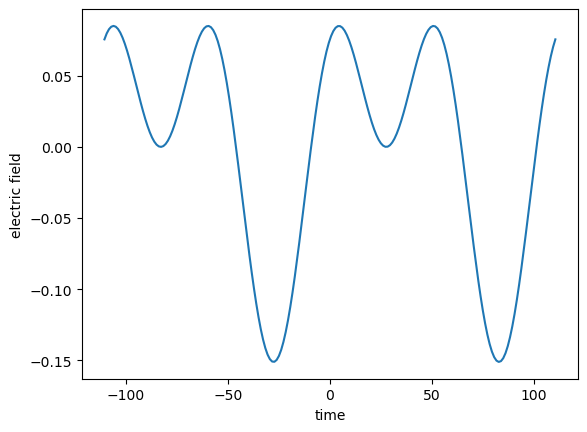

In [5]:
t_list = np.linspace(-TC, TC, 200)  #time list

#define a function for a two-colour field, with mixing angle theta and phase shift phi
def beam(theta, phi, r, s):
    Int_1 = Int_0 * (np.cos(theta))**2  #Intensity of beam 1
    Int_2 = Int_0 * (np.sin(theta))**2  #Intensity of beam 1
    omega_1 = r * omega  #Frequency of beam 1
    omega_2 = s * omega  #Frequency of beam 1

    E_01 = np.sqrt(Int_1 / IAU)  #field strength of beam 1
    E_02 = np.sqrt(Int_2 / IAU)  #field strength of beam 2

    e_field = []  #create empty lists to store electric field values for each point in time

    for i in t_list:
        beam_1 = E_01 * np.sin(omega_1 * i)
        beam_2 = E_02 * np.sin((omega_2 * i) + phi)
        total_beam = beam_1 + beam_2

        e_field.append(total_beam)

    #return e_field
    plt.plot(t_list, e_field, label='two-colour field')
    plt.xlabel("time")
    plt.ylabel("electric field")
    plt.show()

beam(np.pi / 4, np.pi /2, 1, 2)

Creating a timespace domain to make initial guesses:

In [ ]:
'''
# Define grid parameters
real_time = np.linspace(0, TC, 10)  # 50 points from 0 to 100
imag_time = np.linspace(0, TC/2, 10) * 1j   # 50 points from 0 to 50

# Create meshgrid
X, Y = np.meshgrid(real_time, imag_time)

# Combine into complex numbers
time_points = X + Y

#print(time_points)
'''

Find saddle points:

In [6]:
p = 0.5507876985417118  #momentum

def action_drv_mono(t_arr):
    #S_mono = Ip*t + 0.5*p**2*t - (p/omega)*np.cos(omega*t + np.pi/2) + 0.5*t - (1/4*omega)*np.sin(2*omega*t + np.pi)
    t = t_arr[0] + t_arr[1]*1j
    #print(t)
    dS_dt_mono_real = np.real(Ip + 0.5* (p + (np.sin(omega * t)))**2)
    dS_dt_mono_imag = np.imag(Ip + 0.5* (p + (np.sin(omega * t)))**2)

    return np.array([dS_dt_mono_real, dS_dt_mono_imag])



###find saddle points:

ts = []

for m in np.linspace(0, TC, 10):                             #calculate saddle point for every initial guess in timespace
    for n in np.linspace(0, TC/2, 10):
        #print(m+1j*n)
        saddles = fsolve(action_drv_mono, np.array([m,n]), xtol=1e-10)
        saddles = np.round(saddles, 3)
        
        #print(np.linalg.norm(action_drv_mono(saddles)))
        
        if saddles[0] > 0 and saddles[0] < TC:                                   #only keep saddle points with positive real/imag times
            if saddles[1] > 0 and saddles[1] < TC/2:
                if np.linalg.norm(action_drv_mono(saddles)) < 1:
                    ts.append(saddles)

saddle_points = [complex(t[0], t[1]) for t in ts]            # Convert (real, imag) pairs to complex numbers

saddle_points = np.unique(np.round(saddle_points, 3))        # Round to 6 d.p., then remove duplicates


print(saddle_points)


[ 57.69 +35.581j 107.832+35.581j]


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


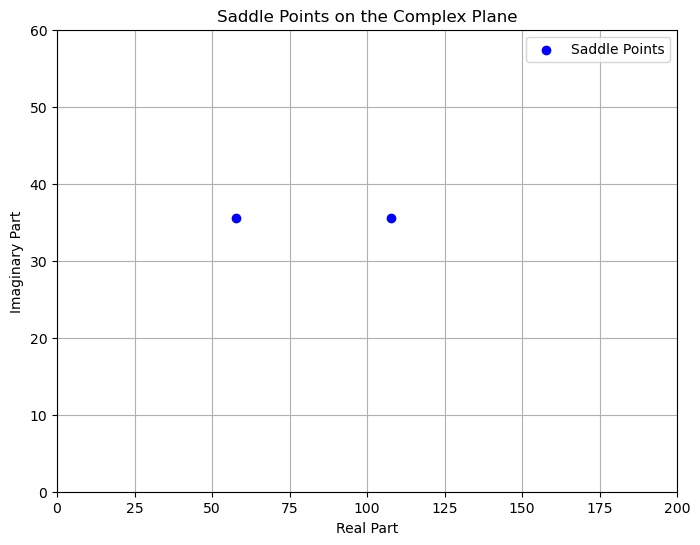

In [7]:
reals = []
imags = []

for point in saddle_points:
    real_part = np.real(point)
    reals.append(real_part)
    
    imag_part = np.imag(point)
    imags.append(imag_part)

plt.figure(figsize=(8, 6))
plt.scatter(reals, imags, color='blue', label='Saddle Points')

plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.xlim(0, 200)  # Set x-axis range (e.g., from 0 to 10)
plt.ylim(0, 60)  # Set y-axis range (e.g., from 0 to 10)
plt.title('Saddle Points on the Complex Plane')
plt.grid(True)
plt.legend()
plt.show()


Check if dS_dt = 0:

In [8]:
#np.append(saddle_points)
for point in saddle_points:
    real_part = np.real(point)
    imag_part = np.imag(point)
    #print(point)
    print(action_drv_mono([real_part, imag_part]))
  

[-6.81794089e-05 -2.67049544e-04]
[-2.97752488e-06 -2.00950803e-04]


Varying momentum:

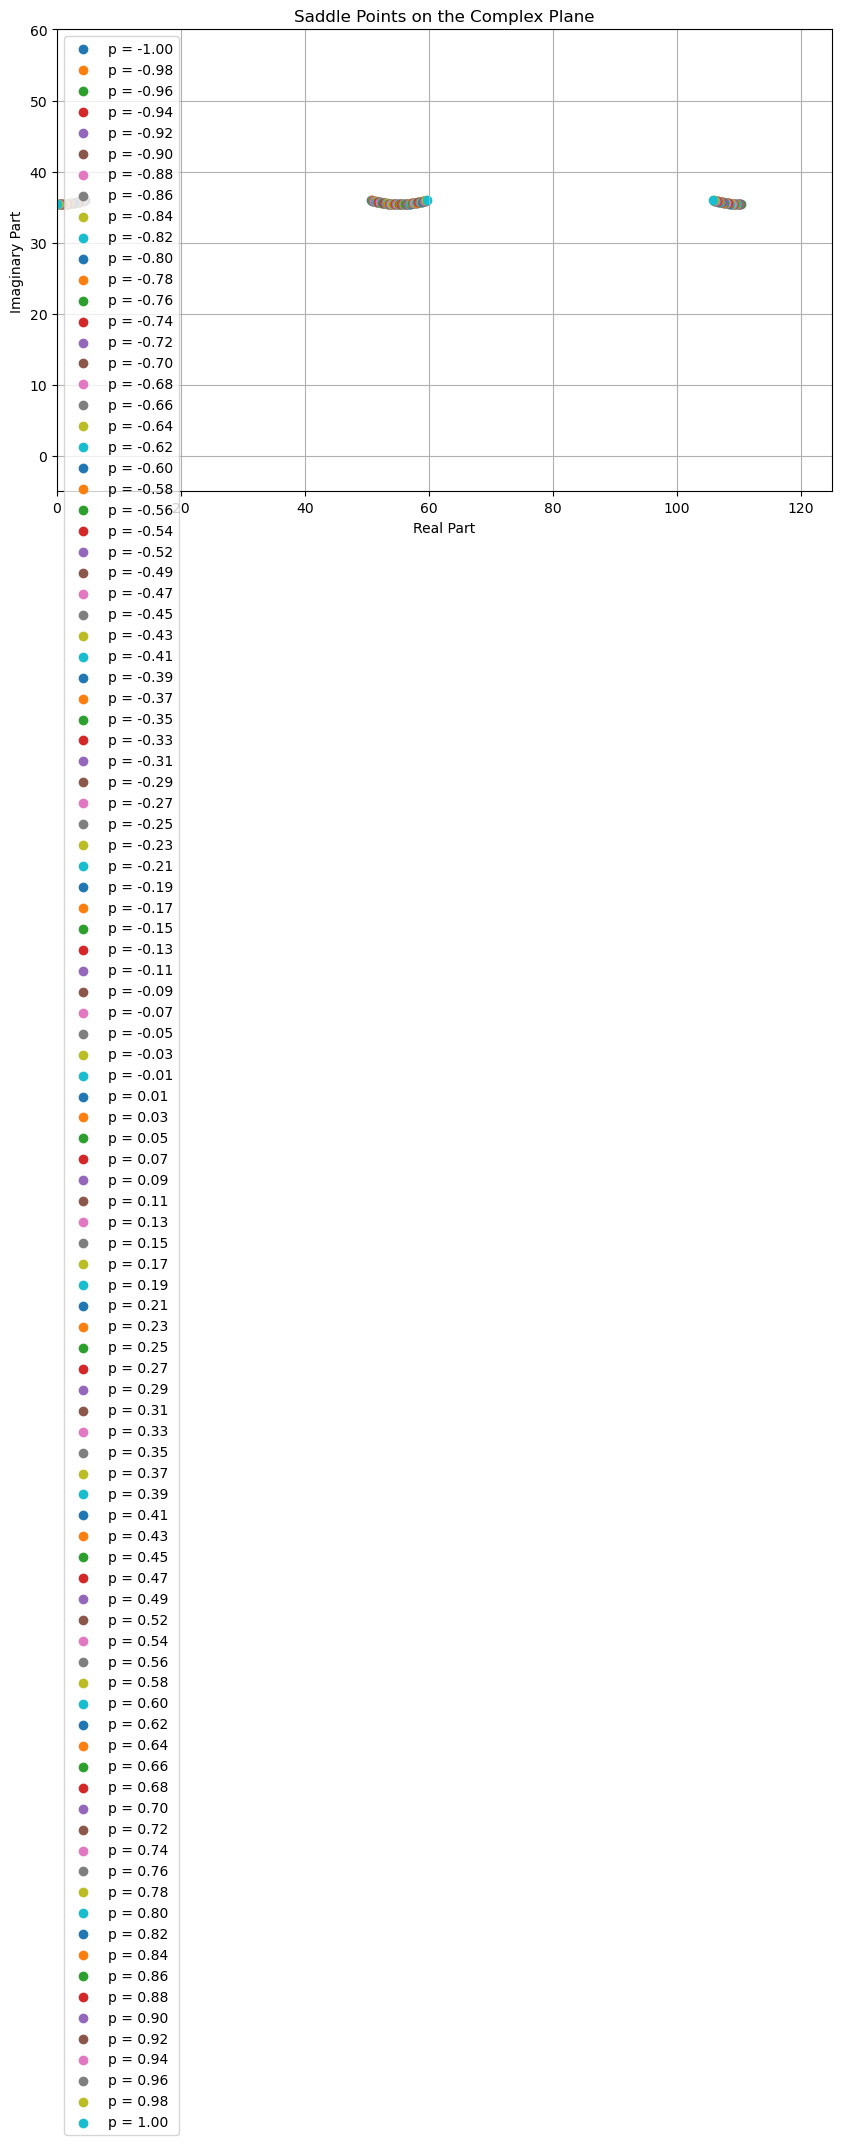

In [9]:
#momentum = [0.] 
momentum = np.linspace(-1.0, 1.0, 100)

plt.figure(figsize=(10, 6))

for p in momentum:
    
    ts = []
    
    def action_drv_mono(t_arr):
        t = t_arr[0] + t_arr[1]*1j

        dS_dt_mono_real = np.real(Ip + 0.5* (p + (np.sin(omega * t)))**2)
        dS_dt_mono_imag = np.imag(Ip + 0.5* (p + (np.sin(omega * t)))**2)

        return np.array([dS_dt_mono_real, dS_dt_mono_imag])

    for m in np.linspace(0, TC, 10):                             #calculate saddle point for every initial guess in timespace
        for n in np.linspace(0, TC/2, 10):
            #print(m+1j*n)
            saddles = fsolve(action_drv_mono, np.array([m,n]), xtol=1e-8)
            saddles = np.round(saddles, 3)

            if saddles[0] > 0 and saddles[0] < TC:                                   #only keep saddle points with positive real/imag times
                if saddles[1] > 0 and saddles[1] < TC/2:
                    if np.linalg.norm(action_drv_mono(saddles)) < 1:
                        ts.append(saddles)

    saddle_points = [complex(t[0], t[1]) for t in ts]            # Convert (real, imag) pairs to complex numbers
    saddle_points = np.unique(np.round(saddle_points, 3))        # Round to 6 d.p., then remove duplicates

    reals = []
    imags = []

    for point in saddle_points:
        real_part = np.real(point)
        reals.append(real_part)

        imag_part = np.imag(point)
        imags.append(imag_part)

    plt.scatter(reals, imags, label=f'p = {p:.2f}')


plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.xlim(0, 125)  # Set x-axis range (e.g., from 0 to 10)
plt.ylim(-5, 60)  # Set y-axis range (e.g., from 0 to 10)
plt.title('Saddle Points on the Complex Plane')
plt.grid(True)
plt.legend()
plt.show()

Checking against analytically-obtained solution:

In [10]:
F0 = 0.053
kappa = 1
gamma = omega * kappa/F0

ts_analytic = []

def analytic_solution(p):
    ts_plus = 1/omega * np.arcsin(gamma * p + gamma * 1j)
    ts_minus = 1/omega * np.arcsin(gamma * p - gamma * 1j)
    
    ts_analytic = [ts_plus, ts_minus]
    return ts_analytic

analytic_solution(0.5507876985417118)

[(6.951001826197784+17.438565228262615j),
 (6.951001826197784-17.438565228262615j)]

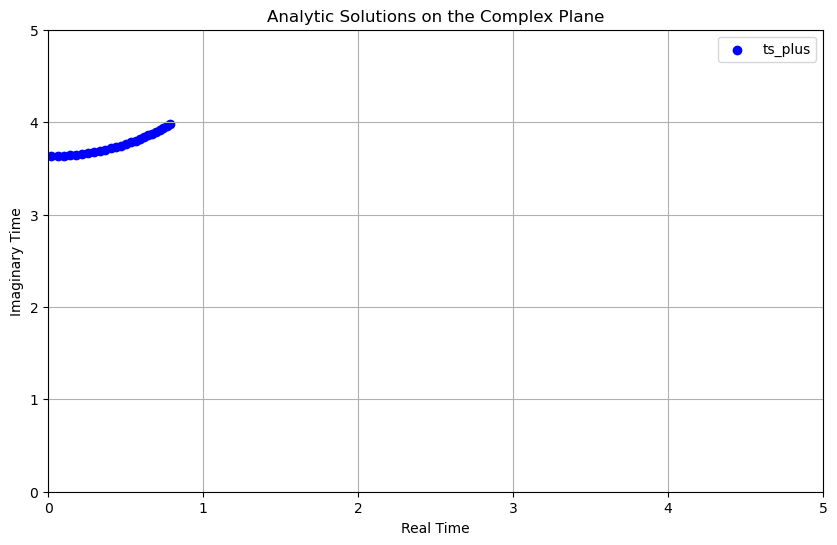

In [11]:
F0 = 0.053
kappa = 1
omega = 1.0  # Replace with your actual value of omega
gamma = omega * kappa / F0

def analytic_solution(p):
    ts_plus = 1 / omega * np.arcsin(gamma * p + gamma * 1j)
    ts_minus = 1 / omega * np.arcsin(gamma * p - gamma * 1j)
    return [ts_plus, ts_minus]

p_values = np.linspace(-1.0, 1.0, 50)  


reals_plus = []
imags_plus = []
#reals_minus = []
#imags_minus = []

# Compute ts_analytic for each p value
for p in p_values:
    ts_plus, ts_minus = analytic_solution(p)
    
    # Extract real and imaginary parts for ts_plus
    reals_plus.append(np.real(ts_plus))
    imags_plus.append(np.imag(ts_plus))
    
    # Extract real and imaginary parts for ts_minus
    #reals_minus.append(np.real(ts_minus))
    #imags_minus.append(np.imag(ts_minus))

# Plot the points
plt.figure(figsize=(10, 6))
plt.scatter(reals_plus, imags_plus, color='blue', label='ts_plus')
#plt.scatter(reals_minus, imags_minus, color='red', label='ts_minus')

# Add labels, title, and grid
plt.xlabel('Real Time')
plt.ylabel('Imaginary Time')
plt.xlim(0, 5)  # Set x-axis range (e.g., from 0 to 10)
plt.ylim(0, 5)  # Set y-axis range (e.g., from 0 to 10)
plt.title('Analytic Solutions on the Complex Plane')
plt.grid(True)
plt.legend()
plt.show()